# Progetto ML/SII 2023/2024

## Analisi ed elaborazione dati

In [311]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import cluster_optics_dbscan
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import seaborn as sns




In [312]:
#lettura dati e pulizia dati con numero di votazioni troppo basse

dataset_prova = pd.read_csv(os.path.join('.', "csv_prova.csv"))
dataset_prova = dataset_prova.set_index('User')

dataset_google_reviews = pd.read_csv(os.path.join('.', "google_review_ratings.csv"))
dataset_google_reviews = dataset_google_reviews.set_index('User')


dataset_google_reviews.replace(0, np.nan, inplace=True)
data_set_shape = dataset_google_reviews.shape
dataset_google_reviews.dropna(thresh = data_set_shape[1]/2, axis=0, inplace=True)
dataset_google_reviews.dropna(thresh = 500, axis=1, inplace=True)
dataset_google_reviews.replace(np.nan, 0, inplace=True)

<Axes: >

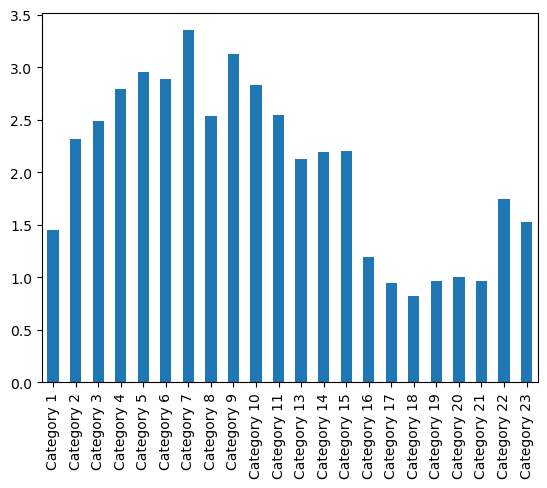

In [313]:
# vediamo la media delle votazioni per ogni categoria per capire quale tipo di scaler utilizzare

dataset_google_reviews.mean().plot(kind='bar')

In [314]:
# possiamo vedere che la media dei voti per ogni categoria è molto diversa, pertanto utilizzeremo un minmax scaler
# per tener conto di queste differenze nel range delle votazioni per categoria

# assumendo che la media per categoria 0.0 per ogni user equivale che un user non abbia votato nulla in quella categoria, eliminiamo
# le categorie e gli user con un numero di votazioni troppo basso
# in piu eliminiamo righe e colonne con un numero di votazioni/votazioni uguali a zero superiori alla metà

In [315]:
minMaxScaler = MinMaxScaler()
dataset_google_reviews = pd.DataFrame(minMaxScaler.fit_transform(dataset_google_reviews), columns=dataset_google_reviews.columns, index=dataset_google_reviews.index)

In [316]:
#vediamo la variazione di varianza all'aumentare del numero di componenti pca per capire se possiamo fare feature selection e riduzione
#della dimensionalità

In [317]:
def grafico_varianza_pca(dataframe):
    
    figure = plt.figure(figsize = (9, 9))
    pca = PCA().fit(dataframe)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('numero componenti')
    plt.ylabel('varianza');
    plt.show()
    
    axx = plt.subplot()
    axx.set_xlim([10,24])
    axx.plot(np.cumsum(pca.explained_variance_ratio_))

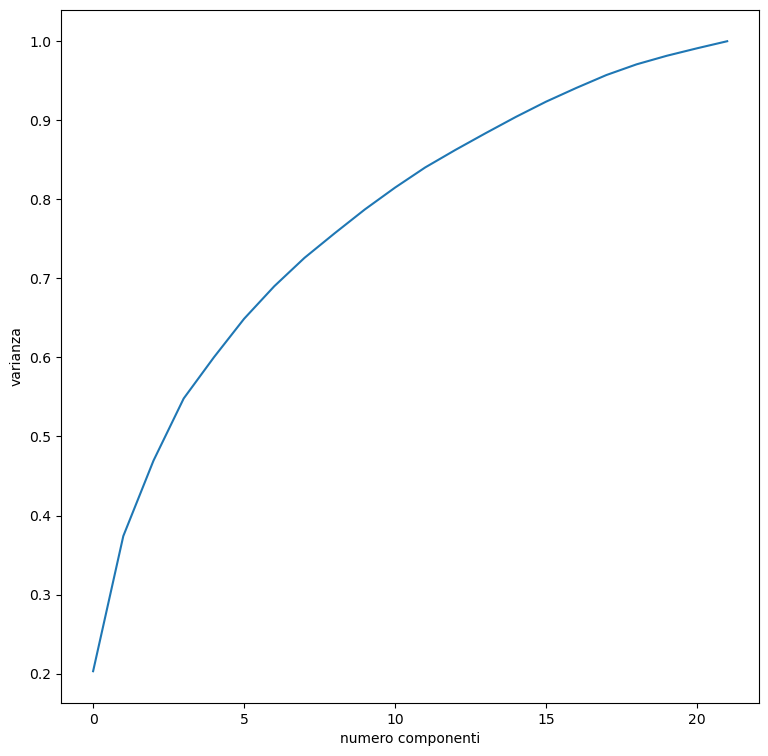

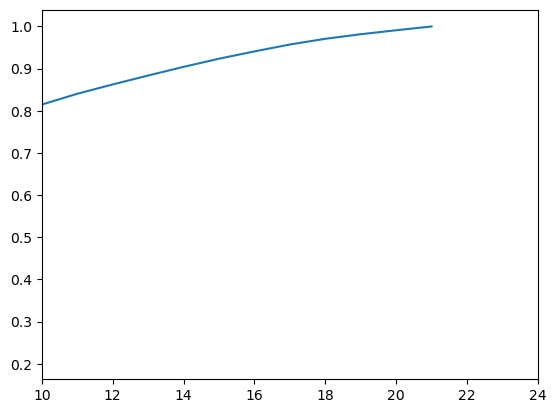

In [318]:
grafico_varianza_pca(dataset_google_reviews)

In [319]:
## se vogliamo applicare riduzione della dimensionalità con PCA per preservare il 90 pecento della varianza, utilizziamo un  numero di componenti pari a 15 togliendone 8

In [320]:
def applica_pca(df, num_components):
    pca15 = PCA(n_components=num_components)
    dataset_google_reviews_copy_reduct = pd.DataFrame(pca15.fit_transform(df))
    dataset_google_reviews_copy_reduct.index = 'User ' + (dataset_google_reviews_copy_reduct.index + 1).astype(str)
    dataset_google_reviews_copy_reduct.columns = 'Autoval ' + (dataset_google_reviews_copy_reduct.columns + 1).astype(str)
    return dataset_google_reviews_copy_reduct

In [321]:
dataset_google_reviews_copy_reduct = applica_pca(dataset_google_reviews, 15)

In [322]:
## Proviamo a trovare dei cluster, troviamo innanzitutto il numero di cluster ottimali mediante il metodo elbow

In [323]:
def elbow_method(dataframe2, lim):
    inertia = []
    K = range(lim[0],lim[1])
    for k in K:
        kmeanModel = KMeans(n_clusters=k, n_init=10).fit(dataframe2)
        inertia.append(kmeanModel.inertia_)

    plt.figure(figsize=(7,7))
    plt.plot(K, inertia, 'bx-')
    plt.xticks(K)
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.show()
    


In [324]:
def trova_eps(df,num_vicini):
    neighbors = NearestNeighbors(n_neighbors=num_vicini, metric = 'cosine')
    neighbors_fit = neighbors.fit(df)
    distances, indices = neighbors_fit.kneighbors(df)

    #plt.figure(figsize = (14, 14))
    #figure = plt.figure(figsize = (18, 18))

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,18))

    #axx = plt.subplot()
    #axx.set_xlim([5440, 5500])
    distances = np.sort(distances, axis=0)
    distances_slice = distances[:,1]
    ax1.plot(distances_slice)


    ax2.set_xlim([5000, 5970])
    ax2.plot(distances_slice)
    
    #print(distances)
    #print(distances_slice.shape)
    #print(distances_slice)

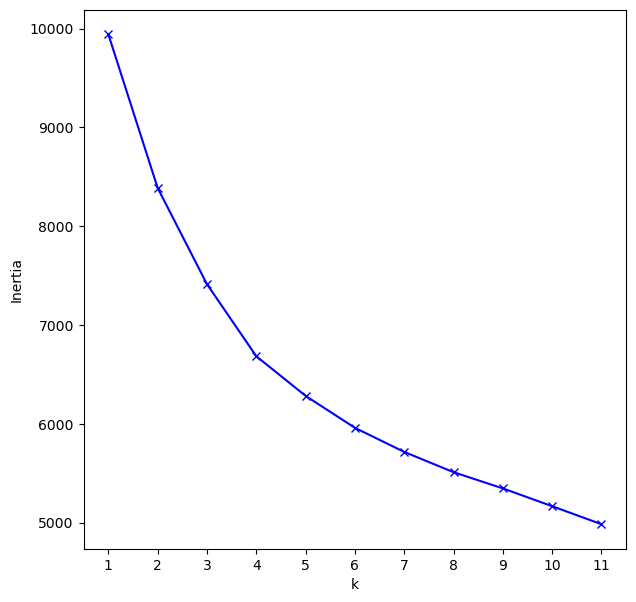

In [325]:
elbow_method(dataset_google_reviews, (1,12))

In [326]:
#elbow_method(dataset_google_reviews_copy_reduct, (4,10))

In [327]:
# il numero di cluster ottimale sembra essere 4 o 5, scegliamo 4 cluster

In [328]:
def clustering_kmeans(df,n_clusters,titolo=''):
    
    dataset_google_reviews_copy = df.copy()
    pca3 = PCA(n_components=3)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++')
    label_clustering = kmeans.fit_predict(dataset_google_reviews_copy)
    dataset_google_reviews_copy["Cluster"] = label_clustering
    dataset_google_reviews_copy["Cluster_label"] = 'Cluster ' + (dataset_google_reviews_copy["Cluster"]).astype(str)
    PCs_3d = pd.DataFrame(pca3.fit_transform(dataset_google_reviews_copy.drop(["Cluster" , "Cluster_label"], axis=1))) 
    colonne=[]
    
    for i in range(3):
        colonne.append("PC{}_3d".format(i+1))
        
    PCs_3d.columns = colonne
    PCs_3d.index = 'User ' + (PCs_3d.index + 1).astype(str)
    dataset_google_reviews_copy = pd.concat([dataset_google_reviews_copy,PCs_3d], axis=1, join='inner')

    #Plot
    
    colors = ['#DF2020', '#81DF20', '#4dabe6', '#FF66FF', '#804000', '#b3b300', '#669999']
    dataset_google_reviews_copy['c'] = dataset_google_reviews_copy['Cluster'].map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 
                                                       5:colors[5], 6:colors[6]})
    
    # trovo cluster center in 3D
    kmeans.fit(PCs_3d)
    centers = kmeans.cluster_centers_
    fig1 = plt.figure(figsize = (18, 18))
    ax = fig1.add_subplot(111, projection = '3d')
    ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                    dataset_google_reviews_copy["PC2_3d"], 
                    dataset_google_reviews_copy["PC3_3d"],
                    marker=".",
                    alpha=0.5,
                    s=30,
                    c=dataset_google_reviews_copy['c'])

    ax.scatter(xs=centers[:,0], ys=centers[:,1], zs=centers[:, 2], color='black',s=400)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(titolo,y=1.05, fontsize=20);    
    fig = px.scatter_3d(dataset_google_reviews_copy, x='PC1_3d', y='PC2_3d', z='PC3_3d',
              color='Cluster_label')
    fig.add_trace(go.Scatter3d(x=centers[:,0], y=centers[:,1], z=centers[:,2],  text="Centroide", mode='markers', marker=dict(size=15, color='black')))
    fig.show()
    

In [329]:
def clustering_agglomerativo(df,n_clusters,link='complete',titolo=''):
    
    dataset_google_reviews_copy = df.copy()
    
    pca3 = PCA(n_components=3)
    
    ag = AgglomerativeClustering(n_clusters=n_clusters, metric ='cosine', linkage=link)
    labels_ac = ag.fit_predict(dataset_google_reviews_copy)
    


    dataset_google_reviews_copy["Cluster"] = labels_ac
    dataset_google_reviews_copy["Cluster_label"] = 'Cluster ' + (dataset_google_reviews_copy["Cluster"]).astype(str)
    
    PCs_3d = pd.DataFrame(pca3.fit_transform(dataset_google_reviews_copy.drop(["Cluster", "Cluster_label"], axis=1)))
    
    colonne=[]
    
    for i in range(3):
        colonne.append("PC{}_3d".format(i+1))
        
    
    PCs_3d.columns = colonne
    PCs_3d.index = 'User ' + (PCs_3d.index + 1).astype(str)
    dataset_google_reviews_copy = pd.concat([dataset_google_reviews_copy,PCs_3d], axis=1, join='inner')

    #Plot
    
    colors = ['#DF2020', '#81DF20', '#4dabe6', '#FF66FF', '#804000', '#b3b300', '#669999']
    dataset_google_reviews_copy['c'] = dataset_google_reviews_copy['Cluster'].map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 
                                                       5:colors[5], 6:colors[6]})

    nc = NearestCentroid()
    nc.fit(PCs_3d, labels_ac)
    centroidi = nc.centroids_
    
    fig1 = plt.figure(figsize = (18, 18))
    
    #if n_components == 3:
       
    ax = fig1.add_subplot(111, projection = '3d')   
    #ax = plt.axes(projection ="3d")
   
    ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                     dataset_google_reviews_copy["PC2_3d"], 
                     dataset_google_reviews_copy["PC3_3d"],
                     marker=".",
                     alpha=0.5,
                     s=30,
                     c=dataset_google_reviews_copy['c'])
    ax.scatter(xs=centroidi[:,0], ys=centroidi[:,1], zs=centroidi[:, 2], color='black',s=400)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(titolo,y=1.05, fontsize=20);
    
    
    # rifaccio grafico in 2d
    
    #pca2 = PCA(n_components=2)

    
    #pca_2d=pca2.fit_transform(dataset_google_reviews)
    
    #pca2d_clust_labels=ag.fit_predict(pca_2d)
    
    #nc = NearestCentroid()
    #nc.fit(pca_2d, pca2d_clust_labels)
    #centroidi2d = nc.centroids_
    
    #fig2 = plt.figure(figsize = (11, 11))
    
    #plot_2d = fig2.add_subplot(212) 
    
    #plot_2d.scatter(pca_2d[:, 0], pca_2d[:, 1], marker=".", c=pca2d_clust_labels, s=50, cmap='viridis')
    
    #plot_2d.scatter(centroidi2d[:, 0], centroidi2d[:, 1], color='black',s=400);
    
    #coeff = np.transpose(pca2.components_[0:2, :])
    #n = coeff.shape[0]
    #labels = list(df.columns)
    
    #else:
        
        #plt.scatter(dataset_google_reviews_copy["PC1_3d"], dataset_google_reviews_copy["PC2_3d"], marker=".", c=dataset_google_reviews_copy['c'])
        #centers = kmeans.cluster_centers_
        #plt.scatter(centroidi[:, 0], centroidi[:, 1], color='black',s=400);
        
    
    fig = px.scatter_3d(dataset_google_reviews_copy, x='PC1_3d', y='PC2_3d', z='PC3_3d',
              color='Cluster_label')
    
    fig.add_trace(go.Scatter3d(x=centroidi[:,0], y=centroidi[:,1], z=centroidi[:,2],  text="Centroide", mode='markers', marker=dict(size=15, color='black')))
    
    fig.show()
        

In [330]:
def cluster_dbscan(df,minimo_esempi,distanza,titolo=''):
    
    dataset_google_reviews_copy = df.copy()
    
    pca3 = PCA(n_components=3)
    
    db_labels = DBSCAN(eps=distanza, min_samples=minimo_esempi,metric='cosine').fit_predict(dataset_google_reviews_copy)

    #print(db_labels)
    
    dataset_google_reviews_copy["Cluster"] = db_labels
    dataset_google_reviews_copy["Cluster_label"] = 'Cluster ' + (dataset_google_reviews_copy["Cluster"]).astype(str)
    
    PCs_3d = pd.DataFrame(pca3.fit_transform(dataset_google_reviews_copy.drop(["Cluster", "Cluster_label"], axis=1)))
    
    nc = NearestCentroid()
    nc.fit(PCs_3d, db_labels)
    centroidi = nc.centroids_
    
    colonne=[]
    
    for i in range(3):
        colonne.append("PC{}_3d".format(i+1))
    
    PCs_3d.columns = colonne
    PCs_3d.index = 'User ' + (PCs_3d.index + 1).astype(str)
    dataset_google_reviews_copy = pd.concat([dataset_google_reviews_copy,PCs_3d], axis=1, join='inner')
    
    #Plot
    fig1 = plt.figure(figsize = (18, 18))

    #if n_components == 3:
        
    ax = fig1.add_subplot(111, projection = '3d')    
    #ax = plt.axes(projection ="3d")
    
    ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                     dataset_google_reviews_copy["PC2_3d"], 
                     dataset_google_reviews_copy["PC3_3d"],
                     marker=".",
                     s=30,
                     c=db_labels)
    
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(titolo,y=1.05, fontsize=20);

    # rifaccio grafico in 2d
    
    #pca2 = PCA(n_components=2)

    
    #pca_2d=pca2.fit_transform(dataset_google_reviews)
    
    #pca2d_clust_labels=DBSCAN(eps=distanza, min_samples=minimo_esempi,metric='cosine').fit_predict(pca_2d)
    
    
    #fig2 = plt.figure(figsize = (11, 11))
    
    #plot_2d = fig2.add_subplot(212) 
    
    #plot_2d.scatter(pca_2d[:, 0], pca_2d[:, 1], c=pca2d_clust_labels, s=50, cmap='viridis')
    
    #plot_2d.scatter(centers2d[:, 0], centers2d[:, 1], color='black',s=400);
    
    #coeff = np.transpose(pca2.components_[0:2, :])
    #n = coeff.shape[0]
    #labels = list(df.columns)
    
    #else:
        
        #plt.scatter(dataset_google_reviews_copy["PC1_3d"], dataset_google_reviews_copy["PC2_3d"], marker=".", c=db_labels)
        
    fig = px.scatter_3d(dataset_google_reviews_copy, x='PC1_3d', y='PC2_3d', z='PC3_3d',
              color='Cluster_label')
    
    fig.add_trace(go.Scatter3d(x=centroidi[:,0], y=centroidi[:,1], z=centroidi[:,2],  text="Centroide", mode='markers', marker=dict(size=15, color='black')))
    
    fig.show()
        

In [331]:
def cluster_hdbscan(df,titolo=''):
    
    dataset_google_reviews_copy = df.copy()
    
    pca3 = PCA(n_components=3)
    
    db_labels = HDBSCAN().fit_predict(dataset_google_reviews_copy)

    #print(db_labels)
    
    dataset_google_reviews_copy["Cluster"] = db_labels
    dataset_google_reviews_copy["Cluster_label"] = 'Cluster ' + (dataset_google_reviews_copy["Cluster"]).astype(str)
    
    PCs_3d = pd.DataFrame(pca3.fit_transform(dataset_google_reviews_copy.drop(["Cluster", "Cluster_label"], axis=1)))
    
    colonne=[]
    
    for i in range(3):
        colonne.append("PC{}_3d".format(i+1))
    
    PCs_3d.columns = colonne
    PCs_3d.index = 'User ' + (PCs_3d.index + 1).astype(str)
    dataset_google_reviews_copy = pd.concat([dataset_google_reviews_copy,PCs_3d], axis=1, join='inner')
    
    #Plot
    fig1 = plt.figure(figsize = (18, 18))

    #if n_components == 3:
        
    ax = fig1.add_subplot(111, projection = '3d')
    ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                     dataset_google_reviews_copy["PC2_3d"], 
                     dataset_google_reviews_copy["PC3_3d"],
                     marker=".",
                     s=30,
                     c=db_labels)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(titolo,y=1.05, fontsize=20);
    
    #else:
        
        #plt.scatter(dataset_google_reviews_copy["PC1_3d"], dataset_google_reviews_copy["PC2_3d"], marker=".", c=db_labels)
        
    # rifaccio grafico in 2d
    
    #pca2 = PCA(n_components=2)

    
    #pca_2d=pca2.fit_transform(df)
    
    #pca2d_clust_labels=HDBSCAN().fit_predict(pca_2d)
    
    #centers2d = kmeans.cluster_centers_
    
    #fig2 = plt.figure(figsize = (11, 11))
    
    #plot_2d = fig2.add_subplot(212) 
    
    #plot_2d.scatter(pca_2d[:, 0], pca_2d[:, 1], c=pca2d_clust_labels, s=50, cmap='viridis')
    
    #plot_2d.scatter(centers2d[:, 0], centers2d[:, 1], color='black',s=400);
    
    fig = px.scatter_3d(dataset_google_reviews_copy, x='PC1_3d', y='PC2_3d', z='PC3_3d',
              color='Cluster_label')
    
    #fig.add_trace(go.Scatter3d(x=centroidi[:,0], y=centroidi[:,1], z=centroidi[:,2],  text="Centroide", mode='markers', marker=dict(size=15, color='black')))
    
    fig.show()

In [332]:
def clustering_affinity(df,titolo=''):
    
    dataset_google_reviews_copy = df.copy()
    
    cosine_sim_matrix = cosine_similarity(dataset_google_reviews_copy)
    
    pca3 = PCA(n_components=3)
    
    spect = AffinityPropagation(affinity='precomputed', copy=False)
    
    label_clustering = spect.fit_predict(cosine_sim_matrix)
    
    #print(label_clustering)
    #print(label_clustering.shape)
    #nc2 = NearestCentroid()
    #nc2.fit(dataset_google_reviews_copy, label_clustering)
    #centroidi2 = nc2.centroids_

    dataset_google_reviews_copy["Cluster"] = label_clustering
    dataset_google_reviews_copy["Cluster_label"] = 'Cluster ' + (dataset_google_reviews_copy["Cluster"]).astype(str)
    
    PCs_3d = pd.DataFrame(pca3.fit_transform(dataset_google_reviews_copy.drop(["Cluster", "Cluster_label"], axis=1)))
    
    #print(centers)
    
    colonne=[]
    
    for i in range(3):
        colonne.append("PC{}_3d".format(i+1))
        
    
    PCs_3d.columns = colonne
    PCs_3d.index = 'User ' + (PCs_3d.index + 1).astype(str)
    dataset_google_reviews_copy = pd.concat([dataset_google_reviews_copy,PCs_3d], axis=1, join='inner')

    #Plot
    
    colors = ['#DF2020', '#81DF20', '#4dabe6', '#FF66FF', '#804000', '#b3b300', '#669999']
    dataset_google_reviews_copy['c'] = dataset_google_reviews_copy['Cluster'].map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 
                                                       5:colors[5], 6:colors[6]})
    
    nc = NearestCentroid()
    nc.fit(PCs_3d, label_clustering)
    centroidi = nc.centroids_
    
    # trovo cluster center in 3D
    
    #kmeans.fit(PCs_3d)
    
    #centers = kmeans.cluster_centers_
    
    #print(centers)
    
    #print(dataset_google_reviews_copy['c'])

    fig1 = plt.figure(figsize = (18, 18))
    
    #if n_components == 3:
        
    ax = fig1.add_subplot(111, projection = '3d') 
    #ax = plt.axes(projection ="3d")
    ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                     dataset_google_reviews_copy["PC2_3d"], 
                     dataset_google_reviews_copy["PC3_3d"],
                     marker=".",
                     alpha=0.5,
                     s=30,
                     c=dataset_google_reviews_copy['c'])
        #print(centers.shape)
        #ax.scatter(xs=centers[:, 0], ys=centers[:, 1], zs=centers[:, 2], c='red', s=500);
    ax.scatter(xs=centroidi[:,0], ys=centroidi[:,1], zs=centroidi[:, 2], color='black',s=400)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(titolo,y=1.05, fontsize=20);
        #ax.savefig('Clustering Result.png')  
    
    #else:
        
        #plt.scatter(dataset_google_reviews_copy["PC1_3d"], dataset_google_reviews_copy["PC2_3d"], marker=".", c=dataset_google_reviews_copy['c'])
        #plt.scatter(centers[:, 0], centers[:, 1], color='black',s=400);
        
    
    # rifaccio grafico in 2d
    
    #pca2 = PCA(n_components=2)
    
    #pca_2d=pca2.fit_transform(df)
    
    #cosine_sim_matrix_2d = cosine_similarity(pca_2d)
    
    #pca2d_clust_labels=spect.fit_predict(cosine_sim_matrix_2d)
    
    #nc.fit(pca_2d, pca2d_clust_labels)
    #centers2d = nc.centroids_
    
    #fig2 = plt.figure(figsize = (11, 11))
    
    #plot_2d = fig2.add_subplot(212) 
    
    #plot_2d.scatter(pca_2d[:, 0], pca_2d[:, 1], marker=".", c=pca2d_clust_labels, s=50, cmap='viridis')
    
    #plot_2d.scatter(centers2d[:, 0], centers2d[:, 1], color='black',s=400);
    
    #coeff = np.transpose(pca2.components_[0:2, :])
    #n = coeff.shape[0]
    #labels = list(df.columns)
   
    #for i in range(n):
        #plot_2d.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        #plot_2d.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
        
    
        
    
    #trace1 = ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                          #dataset_google_reviews_copy["PC2_3d"], 
                          #dataset_google_reviews_copy["PC3_3d"], c=label_clustering)

    #trace2 = ax.scatter3D(cluster1["PC1_3d"], cluster1["PC2_3d"], cluster1["PC3_3d"], c='blue')

    #trace3 = ax.scatter3D(cluster2["PC1_3d"], cluster2["PC2_3d"], cluster2["PC3_3d"], c='red')

    #trace4 = ax.scatter3D(cluster3["PC1_3d"], cluster3["PC2_3d"], cluster3["PC3_3d"], c='yellow')

    #trace5 = ax.scatter3D(cluster4["PC1_3d"], cluster4["PC2_3d"], cluster4["PC3_3d"], c='green')

    #trace6 = ax.scatter3D(cluster5["PC1_3d"], cluster5["PC2_3d"], cluster5["PC3_3d"], c='violet')
    
    fig = px.scatter_3d(dataset_google_reviews_copy, x='PC1_3d', y='PC2_3d', z='PC3_3d',
              color='Cluster_label')
    
    fig.add_trace(go.Scatter3d(x=centroidi[:,0], y=centroidi[:,1], z=centroidi[:,2],  text="Centroide", mode='markers', marker=dict(size=15, color='black')))
    
    fig.show()

In [333]:
def cluster_optics(df,titolo='', max_eps=0.24, min_samples=44):
    
    dataset_google_reviews_copy = df.copy()
    
    pca3 = PCA(n_components=3)
    
    clust = OPTICS(min_samples=min_samples, max_eps=max_eps, metric='cosine')
    
    db_labels = clust.fit_predict(dataset_google_reviews_copy)

    #print(db_labels)
    
    dataset_google_reviews_copy["Cluster"] = db_labels
    dataset_google_reviews_copy["Cluster_label"] = 'Cluster ' + (dataset_google_reviews_copy["Cluster"]).astype(str)
    
    PCs_3d = pd.DataFrame(pca3.fit_transform(dataset_google_reviews_copy.drop(["Cluster", "Cluster_label"], axis=1)))
    
    colonne=[]
    
    for i in range(3):
        colonne.append("PC{}_3d".format(i+1))
    
    PCs_3d.columns = colonne
    PCs_3d.index = 'User ' + (PCs_3d.index + 1).astype(str)
    dataset_google_reviews_copy = pd.concat([dataset_google_reviews_copy,PCs_3d], axis=1, join='inner')
    
    #Plot
    fig1 = plt.figure(figsize = (18, 18))

    #if n_components == 3:
        
    ax = fig1.add_subplot(111, projection = '3d')  
    ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                     dataset_google_reviews_copy["PC2_3d"], 
                     dataset_google_reviews_copy["PC3_3d"],
                     marker=".",
                     s=30,
                     c=db_labels)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(titolo,y=1.05, fontsize=20);
    
    #else:
        
        #plt.scatter(dataset_google_reviews_copy["PC1_3d"], dataset_google_reviews_copy["PC2_3d"], marker=".", c=db_labels)
        
    # rifaccio grafico in 2d
    
    #pca2 = PCA(n_components=2)

    
    #pca_2d=pca2.fit_transform(df)
    
    #pca2d_clust_labels=HDBSCAN().fit_predict(pca_2d)
    
    #centers2d = kmeans.cluster_centers_
    
    #fig2 = plt.figure(figsize = (11, 11))
    
    #plot_2d = fig2.add_subplot(212) 
    
    #plot_2d.scatter(pca_2d[:, 0], pca_2d[:, 1], c=pca2d_clust_labels, s=50, cmap='viridis')
    
    #plot_2d.scatter(centers2d[:, 0], centers2d[:, 1], color='black',s=400);
    
    fig = px.scatter_3d(dataset_google_reviews_copy, x='PC1_3d', y='PC2_3d', z='PC3_3d',
              color='Cluster_label')
    
    #fig.add_trace(go.Scatter3d(x=centroidi[:,0], y=centroidi[:,1], z=centroidi[:,2],  text="Centroide", mode='markers', marker=dict(size=15, color='black')))
    
    fig.show()

In [334]:
def clustering_spettrale(df,n_clusters,precomputed,titolo=''):
    
    dataset_google_reviews_copy = df.copy()
    
    pca3 = PCA(n_components=3)
    
    if precomputed == True:
        cosine_sim_matrix = cosine_similarity(dataset_google_reviews_copy)
        spect = SpectralClustering(n_clusters=n_clusters,affinity='precomputed')
        label_clustering = spect.fit_predict(cosine_sim_matrix)
    else:
        spect = SpectralClustering(n_clusters=n_clusters)
        label_clustering = spect.fit_predict(dataset_google_reviews_copy)
    
    
    
    #print(label_clustering)
    #print(label_clustering.shape)
    #nc2 = NearestCentroid()
    #nc2.fit(dataset_google_reviews_copy, label_clustering)
    #centroidi2 = nc2.centroids_

    dataset_google_reviews_copy["Cluster"] = label_clustering
    dataset_google_reviews_copy["Cluster_label"] = 'Cluster ' + (dataset_google_reviews_copy["Cluster"]).astype(str)
    
    PCs_3d = pd.DataFrame(pca3.fit_transform(dataset_google_reviews_copy.drop(["Cluster", "Cluster_label"], axis=1)))
    
    #print(centers)
    
    colonne=[]
    
    for i in range(3):
        colonne.append("PC{}_3d".format(i+1))
        
    
    PCs_3d.columns = colonne
    PCs_3d.index = 'User ' + (PCs_3d.index + 1).astype(str)
    dataset_google_reviews_copy = pd.concat([dataset_google_reviews_copy,PCs_3d], axis=1, join='inner')

    #Plot
    
    colors = ['#DF2020', '#81DF20', '#4dabe6', '#FF66FF', '#804000', '#b3b300', '#669999']
    dataset_google_reviews_copy['c'] = dataset_google_reviews_copy['Cluster'].map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 
                                                       5:colors[5], 6:colors[6]})
    
    nc = NearestCentroid()
    nc.fit(PCs_3d, label_clustering)
    centroidi = nc.centroids_
    
    # trovo cluster center in 3D
    
    #kmeans.fit(PCs_3d)
    
    #centers = kmeans.cluster_centers_
    
    #print(centers)
    
    #print(dataset_google_reviews_copy['c'])

    fig1 = plt.figure(figsize = (18, 18))
    
    #if n_components == 3:
        
    ax = fig1.add_subplot(111, projection = '3d')    
    #ax = plt.axes(projection ="3d")
    ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                     dataset_google_reviews_copy["PC2_3d"], 
                     dataset_google_reviews_copy["PC3_3d"],
                     marker=".",
                     alpha=0.5,
                     s=30,
                     c=dataset_google_reviews_copy['c'])
        #print(centers.shape)
        #ax.scatter(xs=centers[:, 0], ys=centers[:, 1], zs=centers[:, 2], c='red', s=500);
    ax.scatter(xs=centroidi[:,0], ys=centroidi[:,1], zs=centroidi[:, 2], color='black',s=400)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(titolo,y=1.05, fontsize=20);
        #ax.savefig('Clustering Result.png')  
    
    #else:
        
        #plt.scatter(dataset_google_reviews_copy["PC1_3d"], dataset_google_reviews_copy["PC2_3d"], marker=".", c=dataset_google_reviews_copy['c'])
        #plt.scatter(centers[:, 0], centers[:, 1], color='black',s=400);
        
    
    # rifaccio grafico in 2d
    
    #pca2 = PCA(n_components=2)
    
    #pca_2d=pca2.fit_transform(df)
    
    #cosine_sim_matrix_2d = cosine_similarity(pca_2d)
    
    #pca2d_clust_labels=spect.fit_predict(cosine_sim_matrix_2d)
    
    #nc.fit(pca_2d, pca2d_clust_labels)
    #centers2d = nc.centroids_
    
    #fig2 = plt.figure(figsize = (11, 11))
    
    #plot_2d = fig2.add_subplot(212) 
    
    #plot_2d.scatter(pca_2d[:, 0], pca_2d[:, 1], marker=".", c=pca2d_clust_labels, s=50, cmap='viridis')
    
    #plot_2d.scatter(centers2d[:, 0], centers2d[:, 1], color='black',s=400);
    
    #coeff = np.transpose(pca2.components_[0:2, :])
    #n = coeff.shape[0]
    #labels = list(df.columns)
   
    #for i in range(n):
        #plot_2d.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        #plot_2d.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
        
    
        
    
    #trace1 = ax.scatter3D(dataset_google_reviews_copy["PC1_3d"], 
                          #dataset_google_reviews_copy["PC2_3d"], 
                          #dataset_google_reviews_copy["PC3_3d"], c=label_clustering)

    #trace2 = ax.scatter3D(cluster1["PC1_3d"], cluster1["PC2_3d"], cluster1["PC3_3d"], c='blue')

    #trace3 = ax.scatter3D(cluster2["PC1_3d"], cluster2["PC2_3d"], cluster2["PC3_3d"], c='red')

    #trace4 = ax.scatter3D(cluster3["PC1_3d"], cluster3["PC2_3d"], cluster3["PC3_3d"], c='yellow')

    #trace5 = ax.scatter3D(cluster4["PC1_3d"], cluster4["PC2_3d"], cluster4["PC3_3d"], c='green')

    #trace6 = ax.scatter3D(cluster5["PC1_3d"], cluster5["PC2_3d"], cluster5["PC3_3d"], c='violet')
    
    fig = px.scatter_3d(dataset_google_reviews_copy, x='PC1_3d', y='PC2_3d', z='PC3_3d',
              color='Cluster_label')
    
    fig.add_trace(go.Scatter3d(x=centroidi[:,0], y=centroidi[:,1], z=centroidi[:,2],  text="Centroide", mode='markers', marker=dict(size=15, color='black')))
    
    fig.show()

In [335]:
#cluster_dbscan(dataset_google_reviews_copy_reduct, 44, 0.0003,titolo='A')
#clustering_kmeans(dataset_google_reviews_copy_reduct,4,titolo='a')
#cluster_hdbscan(dataset_google_reviews_copy_reduct,titolo='')
#clustering_spettrale(df,n_clusters,titolo='')

## Sistema di raccomandazione

#### Visualizzazione dati

In [336]:
def trovaSimili(k,model):
    return model.kneighbors([k])

In [337]:
def trovaCategorieSimili(u,model,data):
    
    data = data.T     
    _, indici_simili = trovaSimili(data.loc[u],model)
    indici_simili = indici_simili[0,1:]
    return list(map(lambda x: data.iloc[[x]].index[0],indici_simili.flatten().tolist()))

In [338]:
def trovaSimiliA(u,model,data, type='item'):
    
    if type=='item':
        data = data.T
        
    dist, indici_simili = trovaSimili(data.loc[u],model)
    dist, indici_simili = dist[0, 1:], indici_simili[0,1:]
    
    return dist, indici_simili

In [340]:
def get_rating_medio_user(u):
    
    aux = list(dataset_google_reviews.loc[u])
    res = sum(1 for x in aux if x != 0)
    rating_medio_user = (np.sum(dataset_google_reviews.loc[u]))/res
    
    return rating_medio_user;

In [341]:
def get_rating_medio_user_by_index(indice_u):
    
    aux = list(dataset_google_reviews.iloc[indice_u])
    res = sum(1 for x in aux if x != 0)
    rating_medio_user = (np.sum(dataset_google_reviews.iloc[indice_u]))/res
    
    return rating_medio_user;

In [387]:
def predici_categorie_novote_user_no_rec_ub(data,distances,indices,nn, index_user):
    
    data_copy = data.copy()
    
    sim_us = indices[index_user].tolist()
    us_distances = distances[index_user].tolist()
                
    if index_user in sim_us:
        
        id_us = sim_us.index(index_user)
        sim_us.remove(index_user)
        us_distances.pop(id_us)
                
    user_similarity = [1-x for x in us_distances]
    
    #print(sim_us)
    #print(us_distances)
       
    rating_medio_user = get_rating_medio_user_by_index(index_user)
    
    denominatore = sum(user_similarity)
    
    for n,cat in list(enumerate(data_copy.iloc[index_user].index)):
        
        
        if data_copy.iloc[index_user,n] == 0:
            
            #print((1/np.sum(user_similarity_copy)))
            
            numeratore = 0
            
            for k in range(0, len(user_similarity)):
                
                rating_user_simile = data_copy.iloc[sim_us[k], n]
                rating_medio_user_simile = get_rating_medio_user_by_index(sim_us[k])
                
                numeratore = numeratore + (user_similarity[k] * (rating_user_simile - rating_medio_user_simile))
                
                
            predicted_r = rating_medio_user + (numeratore/denominatore)
                             
            data.iloc[index_user,n] = predicted_r
    
    
    
    

In [388]:
def predici_categorie_novote_user_no_rec(data,distances,indices,nn,index_user):
    
    #print(index_user)
    
    data_copy = data.copy()
    
    for i,k in list(enumerate(data_copy.T.index)):
               
        if data_copy.T.iloc[i, index_user] == 0:
                
                    sim_cat = indices[i].tolist()
                    cat_distances = distances[i].tolist()
                
                    if i in sim_cat:
                        id_cat = sim_cat.index(i)
                        sim_cat.remove(i)
                        cat_distances.pop(id_cat)
                
                    cat_similarity = [1-x for x in cat_distances]
                    cat_similarity_copy = cat_similarity.copy()
                    nominatore = 0
                    for s in range(0, len(cat_similarity)):
                        #print(sim_cat[s])
                        if data_copy.T.iloc[sim_cat[s], index_user] == 0:
                            if len(cat_similarity_copy) == nn:
                              cat_similarity_copy.pop(s)
                            else:
                              cat_similarity_copy.pop(s-(len(cat_similarity)-len(cat_similarity_copy)))
                        else:
                            nominatore = nominatore + cat_similarity[s]*data_copy.T.iloc[sim_cat[s],index_user]
                    if len(cat_similarity_copy) > 0:
                        if sum(cat_similarity_copy) > 0:
                            predicted_r = nominatore/sum(cat_similarity_copy)
                        else:
                            predicted_r = 0
                    else:
                        predicted_r = 0
                
                    data.iloc[index_user,i] = predicted_r

In [389]:
def predici_categorie_novote_user_rec(data,distances,indices,nn,index_user):
    
    data_copy = data.copy()
    
    #print(index_user)
    
    for i,k in list(enumerate(data_copy.T.index)):
    
                
        if data.T.iloc[i, index_user] == 0:
                
                    sim_cat = indices[i].tolist()
                    cat_distances = distances[i].tolist()
                
                    if i in sim_cat:
                        id_cat = sim_cat.index(i)
                        sim_cat.remove(i)
                        cat_distances.pop(id_cat)
                
                    cat_similarity = [1-x for x in cat_distances]
                    cat_similarity_copy = cat_similarity.copy()
                    nominatore = 0
                    for s in range(0, len(cat_similarity)):
                        #print(sim_cat[s])
                        if data.T.iloc[sim_cat[s], index_user] == 0:
                            if len(cat_similarity_copy) == nn:
                              cat_similarity_copy.pop(s)
                            else:
                              cat_similarity_copy.pop(s-(len(cat_similarity)-len(cat_similarity_copy)))
                        else:
                            nominatore = nominatore + cat_similarity[s]*data.T.iloc[sim_cat[s],index_user]
                    if len(cat_similarity_copy) > 0:
                        if sum(cat_similarity_copy) > 0:
                            predicted_r = nominatore/sum(cat_similarity_copy)
                        else:
                            predicted_r = 0
                    else:
                        predicted_r = 0
                
                
                    data.iloc[index_user,i] = predicted_r

In [390]:
def predici_categorie_novote_all_user_no_rec(data, nn):
    dataset_google_reviews_copy_no_rec = data.copy()
    
    #computa matrice di similarita
    model = NearestNeighbors(metric='cosine', algorithm='brute')
    model.fit(dataset_google_reviews_copy_no_rec.T.values)
    distances, indices = model.kneighbors(dataset_google_reviews_copy_no_rec.T.values, n_neighbors=nn)
    
    for i,k in enumerate(dataset_google_reviews_copy_no_rec.index):
        if any(dataset_google_reviews_copy_no_rec.loc[k] == 0):
            predici_categorie_novote_user_no_rec(dataset_google_reviews_copy_no_rec, distances, indices, nn, i)
    
    return dataset_google_reviews_copy_no_rec;

In [391]:
def predici_categorie_novote_all_user_rec(data, nn):
    
    dataset_google_reviews_copy_rec = data.copy()
    
    #computa matrice di similarita
    model = NearestNeighbors(metric='cosine', algorithm='brute')
    model.fit(dataset_google_reviews_copy_rec.T.values)
    distances, indices = model.kneighbors(dataset_google_reviews_copy_rec.T.values, n_neighbors=nn)
    
    for i,k in enumerate(dataset_google_reviews_copy_rec.index):
        if any(dataset_google_reviews_copy_rec.loc[k] == 0):
            predici_categorie_novote_user_rec(dataset_google_reviews_copy_rec, distances, indices, nn, i)
    
    return dataset_google_reviews_copy_rec;

In [392]:
def predici_categorie_novote_all_user_no_rec_ub(data, nn):
    dataset_google_reviews_copy_no_rec_ub = data.copy()
    
    #computa matrice di similarita
    model = NearestNeighbors(metric='correlation', algorithm='brute')
    model.fit(dataset_google_reviews_copy_no_rec_ub.values)
    distances, indices = model.kneighbors(dataset_google_reviews_copy_no_rec_ub.values, n_neighbors=nn)
    
    for i,k in enumerate(dataset_google_reviews_copy_no_rec_ub.index):
        #print(i)
        if any(dataset_google_reviews.loc[k] == 0):
            predici_categorie_novote_user_no_rec_ub(dataset_google_reviews_copy_no_rec_ub, distances, indices, nn, i)
    
    return dataset_google_reviews_copy_no_rec_ub;

In [393]:
dataset_google_reviews

Category 1  Category 2  Category 3  Category 4  Category 5  \
User                                                                    
User 1          0.000       0.000       0.726    0.676259    1.000000   
User 2          0.000       0.000       0.726    0.676259    1.000000   
User 3          0.000       0.000       0.726    0.671463    1.000000   
User 4          0.000       0.100       0.726    0.671463    1.000000   
User 5          0.000       0.000       0.726    0.671463    1.000000   
...               ...         ...         ...         ...         ...   
User 5451       0.182       0.788       0.796    0.467626    0.422680   
User 5452       0.182       1.000       0.800    0.470024    0.425258   
User 5453       0.186       1.000       0.804    0.470024    0.427835   
User 5454       0.188       1.000       0.806    0.472422    0.427835   
User 5455       0.190       0.810       0.810    0.474820    0.430412   

           Category 6  Category 7  Category 8  Category 9  Category 10  ...  \
User                                                                    ...   
User 1       0.465296    1.000000    0.359903    0.358173     0.436754  ...   
User 2       0.465296    1.000000    0.429952    0.358173     0.439141  ...   
User 3       0.465296    1.000000    0.429952    0.358173     0.436754  ...   
User 4       0.465296    1.000000    0.359903    0.358173     0.436754  ...   
User 5       0.465296    1.000000    0.429952    0.358173     0.436754  ...   
...               ...         ...         ...         ...          ...  ...   
User 5451    0.375321    0.340206    0.060386    0.225962     0.059666  ...   
User 5452    0.375321    0.337629    0.055556    0.223558     0.054893  ...   
User 5453    0.375321    0.167526    0.050725    0.221154     0.050119  ...   
User 5454    0.375321    0.162371    0.045894    0.218750     0.045346  ...   
User 5455    0.341902    0.164948    0.041063    0.216346     0.040573  ...   

           Category 14  Category 15  Category 16  Category 17  Category 18  \
User                                                                         
User 1        0.226415        0.348        0.118        0.100        0.000   
User 2        0.226415        0.348        0.118        0.100        0.000   
User 3        0.226415        0.348        0.118        0.100        0.000   
User 4        0.226415        0.348        0.118        0.100        0.000   
User 5        0.226415        0.348        0.118        0.100        0.000   
...                ...          ...          ...          ...          ...   
User 5451     0.129717        0.266        0.134        0.132        0.134   
User 5452     0.125000        1.000        0.132        0.130        0.132   
User 5453     0.120283        0.178        0.130        0.128        0.130   
User 5454     0.115566        0.174        0.130        0.126        0.128   
User 5455     0.110849        1.000        0.128        0.126        0.128   

           Category 19  Category 20  Category 21  Category 22  Category 23  
User                                                                        
User 1           0.100        0.000        0.000          0.0          0.0  
User 2           0.100        0.000        0.000          0.0          0.0  
User 3           0.100        0.000        0.000          0.0          0.0  
User 4           0.100        0.000        0.000          0.0          0.0  
User 5           0.100        0.000        0.000          0.0          0.0  
...                ...          ...          ...          ...          ...  
User 5451        0.318        1.000        0.208          1.0          1.0  
User 5452        0.138        1.000        0.210          1.0          1.0  
User 5453        0.318        0.324        0.212          1.0          1.0  
User 5454        0.148        1.000        0.214          1.0          1.0  
User 5455        0.150        1.000        0.216          1.0          1.0  

[5455 rows x 22 

In [394]:
dataset_prova

Category 1  Category 2  Category 3  Category 4  Category 5
User                                                              
User 1         5.0         3.0         4.0         4.0         0.0
User 2         3.0         1.0         2.0         3.0         3.0
User 3         4.0         3.0         4.0         3.0         5.0
User 4         3.0         3.0         1.0         5.0         4.0
User 5         1.0         5.0         5.0         2.0         1.0

In [395]:
dataset_voti_predetti_noricorsione_ub=predici_categorie_novote_all_user_no_rec_ub(dataset_prova, 3)

In [396]:
dataset_voti_predetti_noricorsione

Category 1  Category 2  Category 3  Category 4  Category 5
User                                                              
User 1         5.0         3.0         4.0         4.0    4.483362
User 2         3.0         1.0         2.0         3.0    3.000000
User 3         4.0         3.0         4.0         3.0    5.000000
User 4         3.0         3.0         1.0         5.0    4.000000
User 5         1.0         5.0         5.0         2.0    1.000000

In [397]:
dataset_voti_predetti_noricorsione=predici_categorie_novote_all_user_no_rec(dataset_google_reviews, 6)

      0         1         2         3         4         5
0   1.0  0.810219  0.805593  0.790543  0.763496  0.743058
1   1.0  0.838295  0.805593  0.758249  0.736512  0.719851
2   1.0  0.842766  0.838295  0.810219  0.809771  0.768073
3   1.0  0.877415  0.842766  0.777892  0.758249  0.743058
4   1.0  0.877415  0.824707  0.809771  0.736512  0.713090
5   1.0  0.824707  0.805468  0.777892  0.768073  0.741861
6   1.0  0.844477  0.824805  0.805468  0.784009  0.737876
7   1.0  0.868466  0.865635  0.824805  0.756819  0.741861
8   1.0  0.878499  0.868466  0.844477  0.760211  0.732401
9   1.0  0.878499  0.865635  0.818864  0.784009  0.707409
10  1.0  0.818864  0.760211  0.756819  0.698269  0.661484
11  1.0  0.739499  0.660952  0.635236  0.608678  0.603877
12  1.0  0.739499  0.699190  0.603059  0.590138  0.563685
13  1.0  0.718569  0.699190  0.697287  0.675663  0.668928
14  1.0  0.692526  0.659846  0.648592  0.620126  0.617092
15  1.0  0.735372  0.692526  0.652940  0.597009  0.593672
16  1.0  0.735

In [375]:
dataset_voti_predetti_noricorsione

Category 1  Category 2  Category 3  Category 4  Category 5  \
User                                                                    
User 1       0.702205    0.693018       0.726    0.676259    1.000000   
User 2       0.702205    0.693018       0.726    0.676259    1.000000   
User 3       0.699910    0.691826       0.726    0.671463    1.000000   
User 4       0.495031    0.100000       0.726    0.671463    1.000000   
User 5       0.699910    0.691826       0.726    0.671463    1.000000   
...               ...         ...         ...         ...         ...   
User 5451    0.182000    0.788000       0.796    0.467626    0.422680   
User 5452    0.182000    1.000000       0.800    0.470024    0.425258   
User 5453    0.186000    1.000000       0.804    0.470024    0.427835   
User 5454    0.188000    1.000000       0.806    0.472422    0.427835   
User 5455    0.190000    0.810000       0.810    0.474820    0.430412   

           Category 6  Category 7  Category 8  Category 9  Category 10  ...  \
User                                                                    ...   
User 1       0.465296    1.000000    0.359903    0.358173     0.436754  ...   
User 2       0.465296    1.000000    0.429952    0.358173     0.439141  ...   
User 3       0.465296    1.000000    0.429952    0.358173     0.436754  ...   
User 4       0.465296    1.000000    0.359903    0.358173     0.436754  ...   
User 5       0.465296    1.000000    0.429952    0.358173     0.436754  ...   
...               ...         ...         ...         ...          ...  ...   
User 5451    0.375321    0.340206    0.060386    0.225962     0.059666  ...   
User 5452    0.375321    0.337629    0.055556    0.223558     0.054893  ...   
User 5453    0.375321    0.167526    0.050725    0.221154     0.050119  ...   
User 5454    0.375321    0.162371    0.045894    0.218750     0.045346  ...   
User 5455    0.341902    0.164948    0.041063    0.216346     0.040573  ...   

           Category 14  Category 15  Category 16  Category 17  Category 18  \
User                                                                         
User 1        0.226415        0.348        0.118        0.100     0.105357   
User 2        0.226415        0.348        0.118        0.100     0.105357   
User 3        0.226415        0.348        0.118        0.100     0.105357   
User 4        0.226415        0.348        0.118        0.100     0.105357   
User 5        0.226415        0.348        0.118        0.100     0.105357   
...                ...          ...          ...          ...          ...   
User 5451     0.129717        0.266        0.134        0.132     0.134000   
User 5452     0.125000        1.000        0.132        0.130     0.132000   
User 5453     0.120283        0.178        0.130        0.128     0.130000   
User 5454     0.115566        0.174        0.130        0.126     0.128000   
User 5455     0.110849        1.000        0.128        0.126     0.128000   

           Category 19  Category 20  Category 21  Category 22  Category 23  
User                                                                        
User 1           0.100        0.100     0.726000     0.700822     0.701448  
User 2           0.100        0.100     0.726000     0.700822     0.701448  
User 3           0.100        0.100     0.726000     0.698395     0.699081  
User 4           0.100        0.100     0.412486     0.698395     0.699081  
User 5           0.100        0.100     0.726000     0.698395     0.699081  
...                ...          ...          ...          ...          ...  
User 5451        0.318        1.000     0.208000     1.000000     1.000000  
User 5452        0.138        1.000     0.210000     1.000000     1.000000  
User 5453        0.318        0.324     0.212000     1.000000     1.000000  
User 5454        0.148        1.000     0.214000     1.000000     1.000000  
User 5455        0.150        1.000     0.216000     1.000000     1.000000  

[5455 rows x 22 

In [193]:
#dataset_voti_predetti_ricorsione=predici_categorie_novote_all_user_rec(dataset_google_reviews, 6)

In [194]:
#applichiamo pca anche ai dataset con le votazioni predette
dataset_google_reviews_copy_no_rec = applica_pca(dataset_voti_predetti_noricorsione_ub, 15)
#dataset_google_reviews_copy_rec = applica_pca(dataset_google_reviews_copy_rec, 15)

# RISULTATI

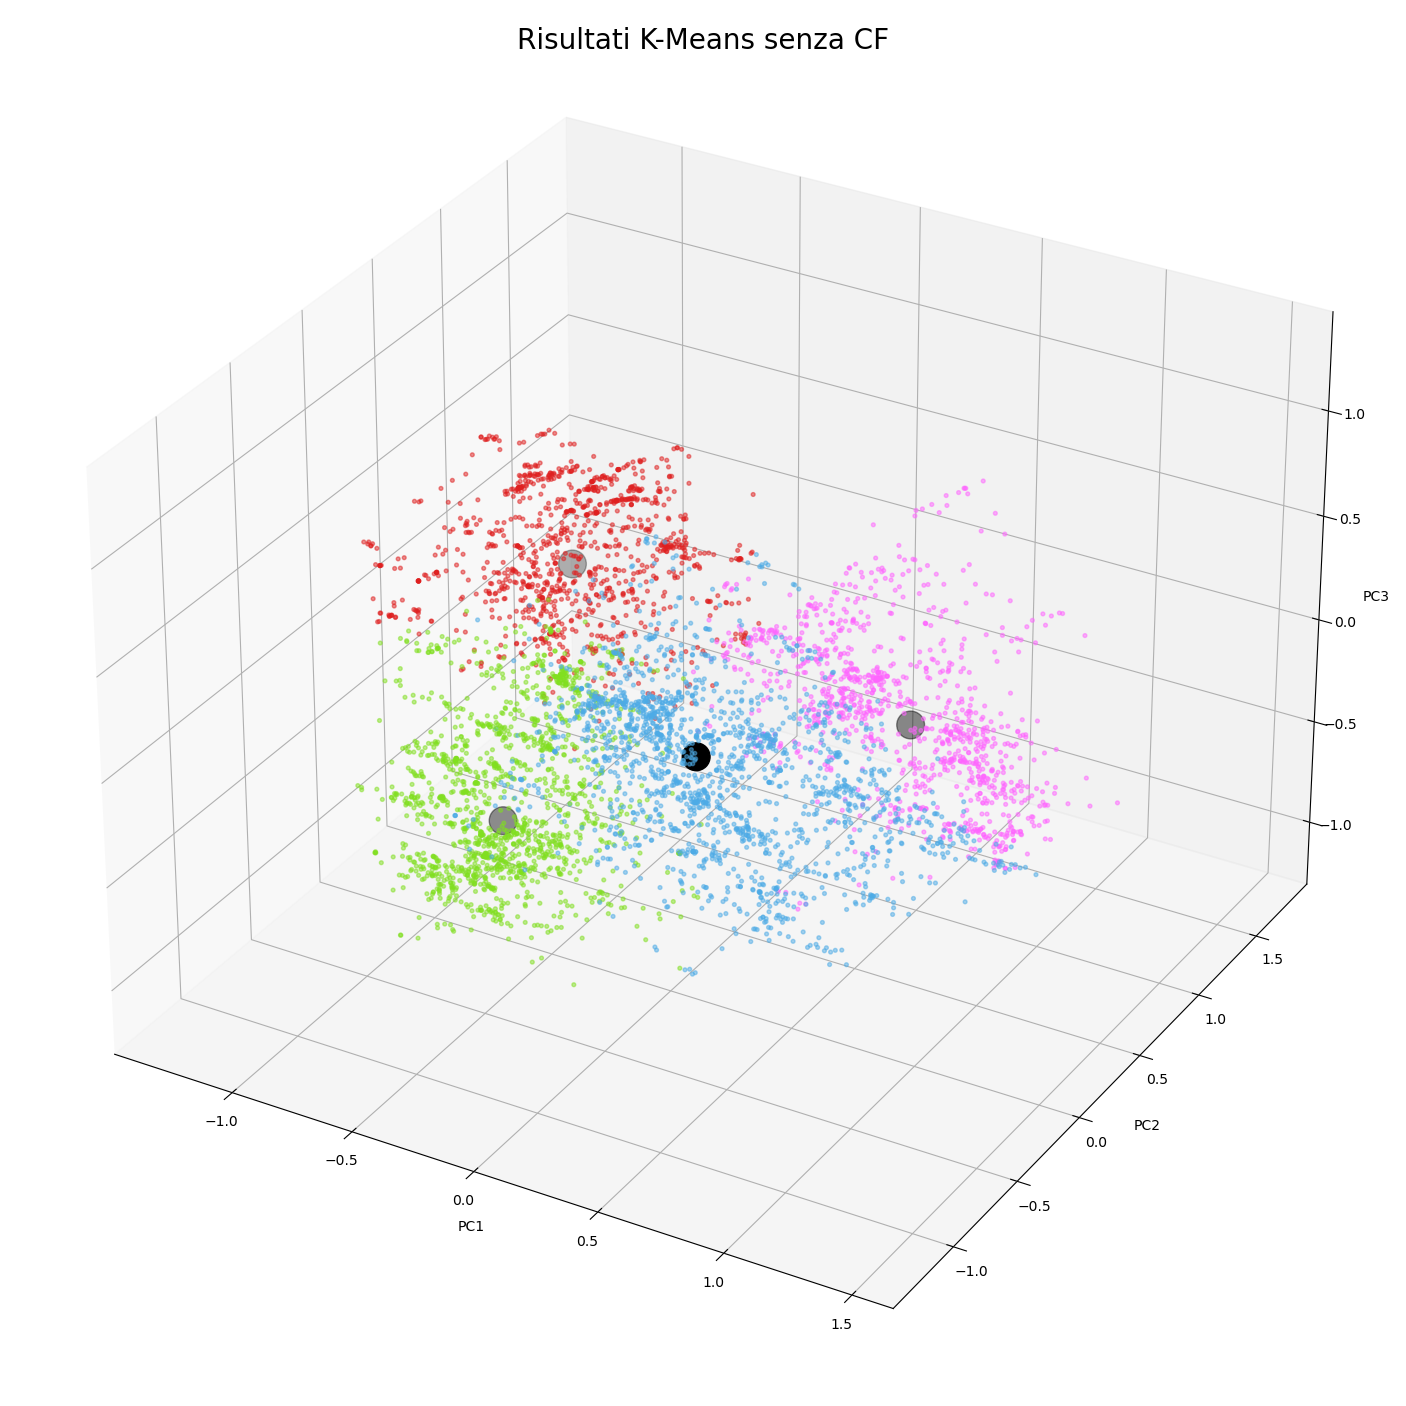

In [195]:
clustering_kmeans(dataset_google_reviews_copy_reduct,4,'Risultati K-Means senza CF')

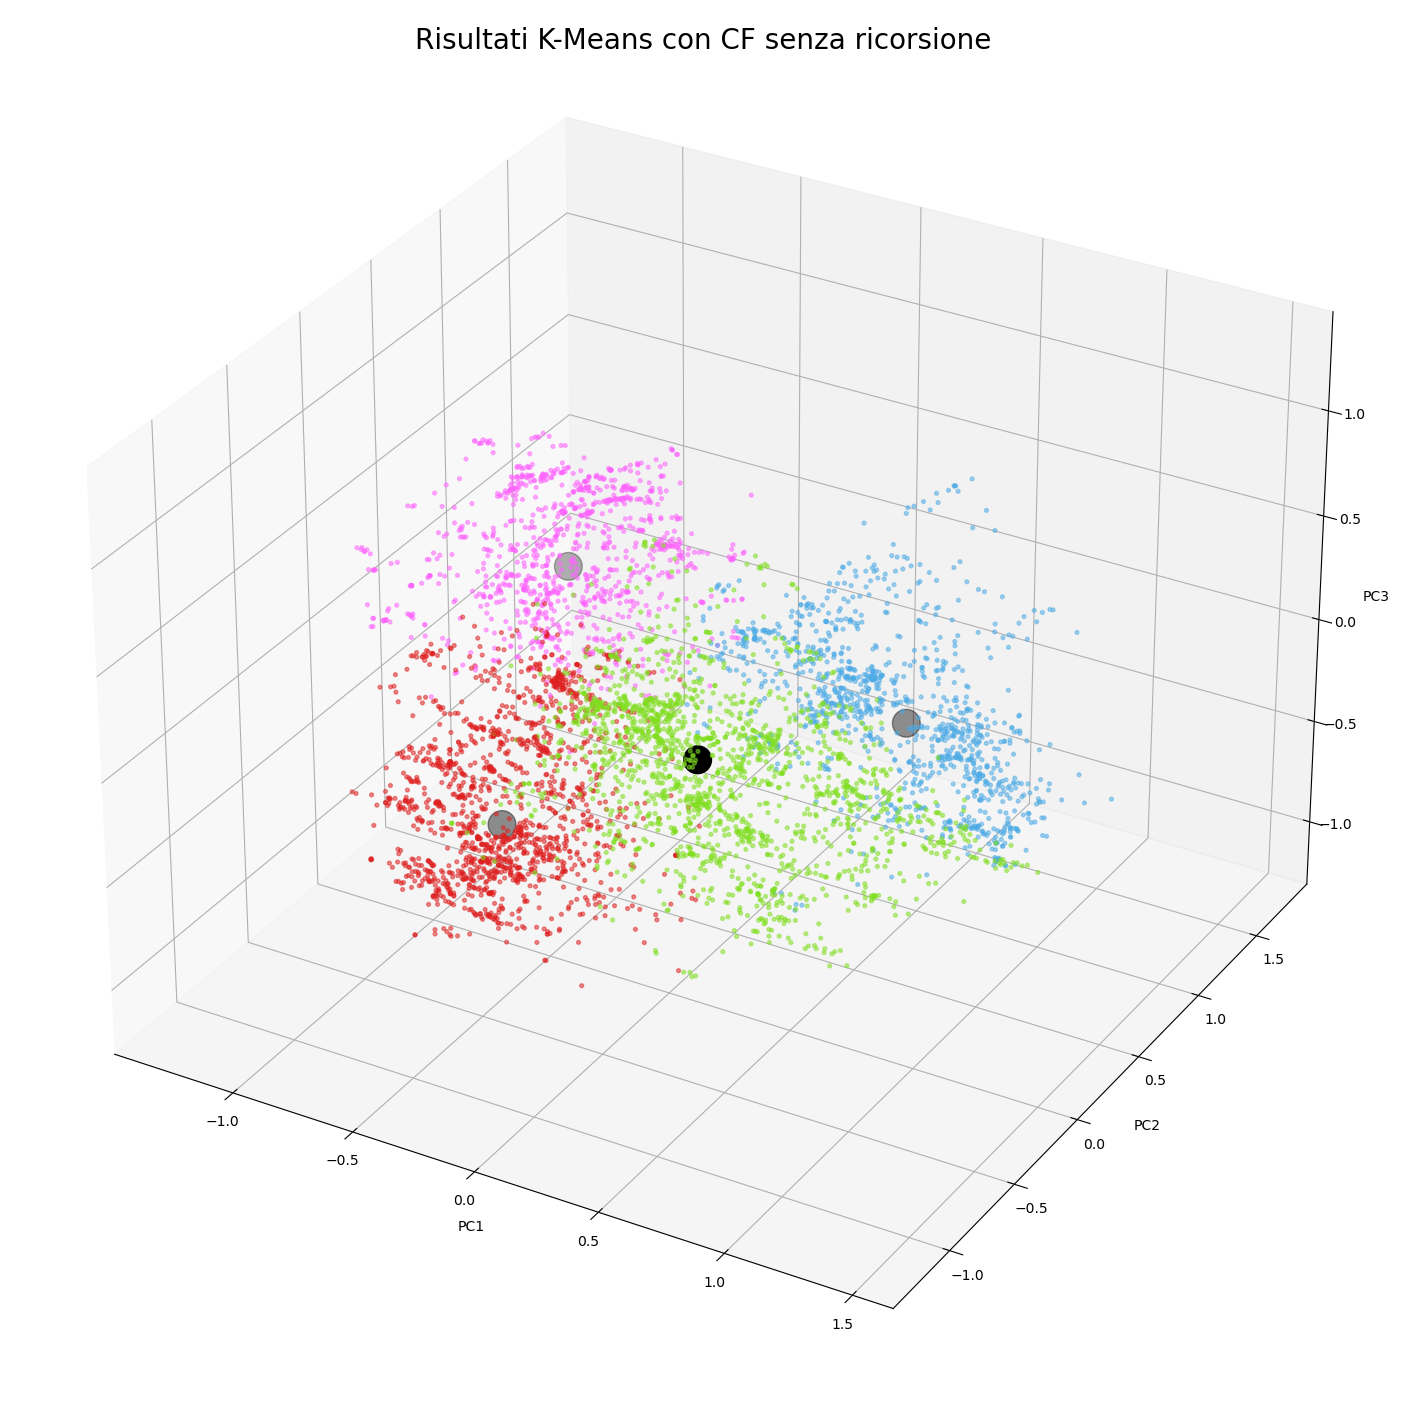

In [196]:
clustering_kmeans(dataset_voti_predetti_noricorsione_ub,4,'Risultati K-Means con CF senza ricorsione')
#clustering_kmeans(dataset_google_reviews_copy_no_rec, 'Risultati K-Means con CF senza ricorsione', 5, 3)

In [ ]:
#clustering_kmeans(dataset_google_reviews_copy_rec,6,'Risultati K-Means con CF con ricorsione')

In [ ]:
clustering_agglomerativo(dataset_google_reviews_copy_reduct,4,'average','Risultati agglomerativo senza CF')

In [ ]:
clustering_agglomerativo(dataset_google_reviews_copy_no_rec,4,'average','Risultati agglomerativo con CF senza ricorsione')

In [ ]:
clustering_spettrale(dataset_google_reviews,4,True,titolo='Risultati clustering spettrale senza CF precumputed')

In [ ]:
clustering_spettrale(dataset_google_reviews,4,False,titolo='Risultati clustering spettrale senza CF con kernel')

In [ ]:
clustering_spettrale(dataset_voti_predetti_noricorsione,4,True,titolo='Risultati clustering spettrale con CF matrice affinità precoumputed')

In [ ]:
clustering_spettrale(dataset_voti_predetti_noricorsione,4,False,titolo='Risultati clustering spettrale con CF con funzioni kernel')

## Clustering basato su densità (DBSCAN - HDBSCAN - OPTICS)

In [ ]:
#cluster_hdbscan(dataset_google_reviews_copy_reduct,titolo='HDBSCAN senza CF')

In [ ]:
# utilizzando l'euristica min_samples = 2D dove D è il numero di dimensioni, plottiamo per numero vicini = min_samples la distanza di ciascun punto e ordiniamo per distanza
#prendiamo l'elbow della curva che corrisponde a circa 0.17

In [ ]:
np.shape(dataset_google_reviews)

In [ ]:
trova_eps(dataset_google_reviews, 44)

In [ ]:
cluster_dbscan(dataset_google_reviews,100,0.07,titolo='DBSCAN senza CF')

In [ ]:
#cluster_optics(dataset_google_reviews_copy_reduct,titolo='OPTIC senza CF')
cluster_optics(dataset_google_reviews,titolo='OPTIC senza CF', max_eps=0.3, min_samples=44)

In [ ]:
#clustering_affinity(dataset_voti_predetti_noricorsione,titolo='')

In [ ]:
#clustering_agglomerativo(dataset_google_reviews_copy_rec,6,'average','Risultati agglomerativo con CF senza ricorsione')

In [254]:
#trova_eps(dataset_google_reviews_copy_reduct)

In [255]:
#cluster_hdbscan(dataset_google_reviews_copy_reduct, 44, 0.006,titolo='A')

In [256]:
#dataset_google_reviews_copy_no_rec_pca = pca.fit_transform(dataset_google_reviews_copy_no_rec)
#dataset_google_reviews_copy_rec_pca = pca.fit_transform(dataset_google_reviews_copy_rec)

In [257]:
#label_no_rec = kmeans.fit_predict(dataset_google_reviews_copy_no_rec_pca)

In [60]:
#label_rec = kmeans.fit_predict(dataset_google_reviews_copy_rec_pca)

In [61]:
# clustering senza collaborative filtering

#plt.figure(figsize = (14, 14))
#plt.scatter(dataset_google_reviews_scaled_pca[:, 0], dataset_google_reviews_scaled_pca[:, 1], c=label, s=50, cmap='viridis')

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='#c22604', s=200, alpha=1);

In [65]:
# clustering con collaborative filtering senza ricorsione
#plt.figure(figsize = (14, 14))
#plt.scatter(dataset_google_reviews_copy_no_rec_pca[:, 0], dataset_google_reviews_copy_no_rec_pca[:, 1], c=label_no_rec, s=50, cmap='viridis')

#centers_no_rec_pca = kmeans.cluster_centers_
#plt.scatter(centers_no_rec_pca[:, 0], centers_no_rec_pca[:, 1], c='#c22604', s=200);

In [66]:
# clustering con collaborative filtering con ricorsione
#plt.figure(figsize = (14, 14))
#plt.scatter(dataset_google_reviews_copy_rec_pca[:, 0], dataset_google_reviews_copy_rec_pca[:, 1], c=label_rec, s=50, cmap='viridis')

#centers_rec_pca = kmeans.cluster_centers_
#plt.scatter(centers_rec_pca[:, 0], centers_rec_pca[:, 1], c='#c22604', s=200);

In [67]:
# vediamo che alcuni punti specialmente nella versione ricorsiva vengono assegnati ad altri cluster, proviamo con altre tecniche di clustering 

In [68]:
#ag = AgglomerativeClustering(n_clusters=5)
#labels_ac_no_rec = ag.fit_predict(dataset_google_reviews_copy_no_rec_pca)

In [69]:
#nc = NearestCentroid()
#nc.fit(dataset_google_reviews_copy_no_rec_pca, labels_ac_no_rec)
#centroidi_no_rec_pca = nc.centroids_

In [70]:
#plt.figure(figsize = (14, 14))
#plt.scatter(dataset_google_reviews_copy_no_rec_pca[:, 0], dataset_google_reviews_copy_no_rec_pca[:, 1], c=labels_ac_no_rec, s=50, cmap='viridis')
#plt.scatter(centroidi_no_rec_pca[:, 0], centroidi_no_rec_pca[:, 1], c='#c22604', s=200);

In [71]:
# vediamo che minimizzando la somma del quadrato delle distanze per ciascun cluster usando la distanza euclidea, il risultato
# non è buono, escono diversi punti clusterizzati male, utilizziamo quindi come metrica la coseno similarità che è quella usata per il collaborative filtering
# per predirre i rating vuoti


In [72]:
#ag = AgglomerativeClustering(affinity ='cosine', linkage='complete', n_clusters=5)
#labels_ac_no_rec = ag.fit_predict(dataset_google_reviews_copy_no_rec_pca)

In [73]:
#nc.fit(dataset_google_reviews_copy_no_rec_pca, labels_ac_no_rec)
#centroidi_no_rec_pca = nc.centroids_

In [74]:
#plt.figure(figsize = (14, 14))
#plt.scatter(dataset_google_reviews_copy_no_rec_pca[:, 0], dataset_google_reviews_copy_no_rec_pca[:, 1], c=labels_ac_no_rec, s=50, cmap='viridis')
#plt.scatter(centroidi_no_rec_pca[:, 0], centroidi_no_rec_pca[:, 1], c='#c22604', s=200);

In [75]:
#proviamo 

In [76]:
#labels_ac_rec = ag.fit_predict(dataset_google_reviews_copy_rec_pca)

In [77]:
#nc.fit(dataset_google_reviews_copy_rec_pca, labels_ac_rec)
#centroidi_rec_pca = nc.centroids_

In [78]:
#plt.figure(figsize = (14, 14))
#plt.scatter(dataset_google_reviews_copy_rec_pca[:, 0], dataset_google_reviews_copy_rec_pca[:, 1], c=labels_ac_rec, s=50, cmap='viridis')
#plt.scatter(centroidi_rec_pca[:, 0], centroidi_rec_pca[:, 1], c='#c22604', s=200);

In [168]:
#neighbors = NearestNeighbors(n_neighbors=44, metric = 'cosine')
#neighbors_fit = neighbors.fit(dataset_google_reviews_copy_no_rec_pca)
#distances, indices = neighbors_fit.kneighbors(dataset_google_reviews_copy_no_rec_pca)

In [169]:
#plt.figure(figsize = (14, 14))
#figure = plt.figure(figsize = (18, 18))
#axx = plt.subplot()
#axx.set_xlim([5440, 5500])
#distances = np.sort(distances, axis=0)
#distances_slice = distances[:,1]
#axx.plot(distances_slice)

In [170]:
#plt.figure(figsize = (14, 14))
#figure = plt.figure(figsize = (18, 18))
#axx = plt.subplot()
#axx.set_xlim([5440, 5470])
#distances = np.sort(distances, axis=0)
#distances_slice = distances[:,1]
#axx.plot(distances_slice)

In [171]:
#clust = OPTICS(min_samples=44, metric='cosine', cluster_method='dbscan', max_eps=0.002)

#clust.fit(dataset_google_reviews_copy_no_rec_pca)


# Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#n_noise_ = list(labels).count(-1)

In [172]:
#plt.figure(figsize=(10, 7))
#G = gridspec.GridSpec(2, 3)
#ax2 = plt.subplot(G[0, :])

#colors = ["g.", "r.", "b.", "y.", "c."]
#for klass, color in zip(range(0, 5), colors):
    #Xk = dataset_google_reviews_copy_no_rec_pca[clust.labels_ == klass]
    #ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
#ax2.plot(dataset_google_reviews_copy_no_rec_pca[clust.labels_ == -1, 0], dataset_google_reviews_copy_no_rec_pca[clust.labels_ == -1, 1], "k+", alpha=0.1)
#ax2.set_title("OPTICS")

In [173]:
#plt.figure(figsize = (14, 14))
#unique_labels = set(labels)
#core_samples_mask = np.zeros_like(labels, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True

#colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
#for k, col in zip(unique_labels, colors):
    #if k == -1:
        # Black used for noise.
        #col = [0, 0, 0, 1]

    #class_member_mask = labels == k

   # xy = dataset_google_reviews_copy_no_rec_pca[class_member_mask & core_samples_mask]
    #plt.plot(
        #xy[:, 0],
        #xy[:, 1],
        #"o",
        #markerfacecolor=tuple(col),
        #markeredgecolor="k",
        #markersize=14,
    #)

    #xy = dataset_google_reviews_copy_no_rec_pca[class_member_mask & ~core_samples_mask]
    #plt.plot(
        #xy[:, 0],
        #xy[:, 1],
        #"o",
        #markerfacecolor=tuple(col),
        #markeredgecolor="k",
        #markersize=6,
    #)

#plt.title(f"Clusters stimati: {n_clusters_}")
#plt.show()